# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

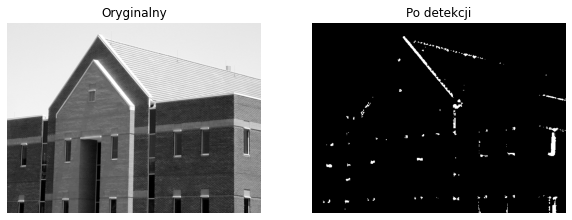

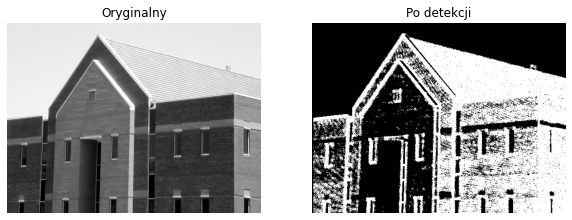

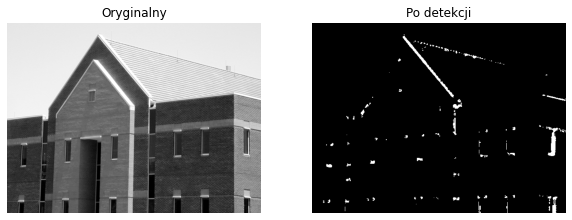

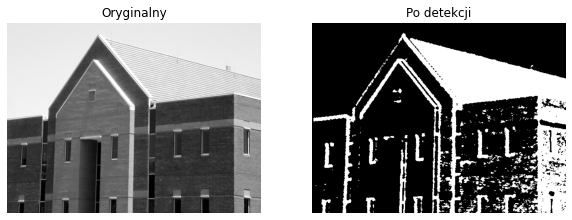

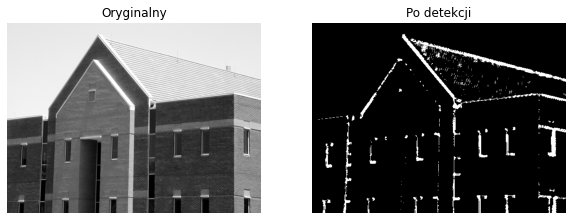

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import wget
import os

if not os.path.exists("dom.png") :
    wget.download('https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png') #--no-check-certificate

dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

def crossing(LoG, thr, kernel_size):
    dst = np.ndarray(LoG.shape)
    X, Y = LoG.shape
    for x in range(3, X):
        for y in range(3, Y):
            okno = LoG[x - 3 : x + 3 , y - 3 : y + 3]
            if np.min(okno) * np.max(okno) < 0:
                if LoG[x, y] > 0:
                    dst[x, y] = LoG[x, y] + np.abs(np.min(okno))
                elif LoG[x, y] < 0:
                    dst[x, y] = np.abs(LoG[x, y]) + np.max(okno)
    dst.astype('uint8')
    dst_progowanie = dst >= thr
    dst_progowanie.astype('uint8')
    dst_blur = cv2.medianBlur(np.float32(dst_progowanie), kernel_size)
    return dst_blur

def Gauss_Laplacian(img, fsize, sigma, thresh):
    img_blur = cv2.GaussianBlur(img, (fsize, fsize), sigma)
    img_L = cv2.Laplacian(img_blur, cv2.CV_32F)

    img_dst = crossing(img_L, thresh, fsize)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(img, 'gray')
    ax1.axis('off')
    ax1.set_title('Oryginalny')
    ax2.imshow(img_dst, 'gray')
    ax2.axis('off')
    ax2.set_title('Po detekcji')
    plt.show()
    
Gauss_Laplacian(dom, 3, 5, 65)
Gauss_Laplacian(dom, 1, 5, 65)
Gauss_Laplacian(dom, 3, 2, 65)
Gauss_Laplacian(dom, 3, 0.5, 65)
Gauss_Laplacian(dom, 3, 0, 65)

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

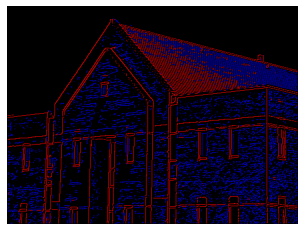

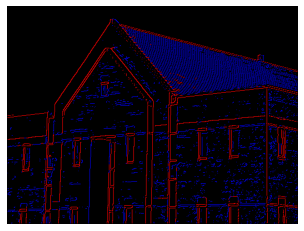

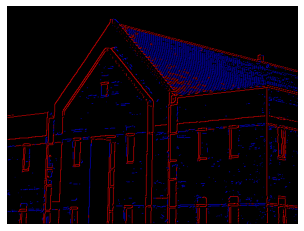

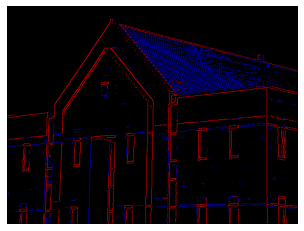

In [2]:
dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

def nonmax(fi, A):
    Y, X = A.shape
    dst = np.zeros((Y, X))
    for x in range(1, X - 1):
        for y in range(1, Y - 1):

            if -67.5 > fi[y, x] > -112.5 or 67.5 < fi[y, x] < 112.5:
                if A[y, x] >=A[y, x+1] and A[y, x] >= A[y, x-1]:
                    dst[y, x] = A[y, x]

            elif 22.5 > fi[y, x] > -22.5 or 157.5 < fi[y, x] < 180 and -180 < fi[y, x] < -157.5:
                if A[y, x] >= A[y+1, x] and A[y, x] >= A[y-1, x]:
                    dst[y, x] = A[y, x]

            elif 157.5 > fi[y, x] > 112.5 or -67.5 < fi[y, x] < -22.5:
                if A[y, x] >= A[y+1, x-1] and A[y, x] >= A[y-1, x+1]:
                    dst[y, x] = A[y, x]

            else:
                if A[y, x] >= A[y+1, x+1] and A[y, x] >= A[y-1, x-1]:
                    dst[y, x] = A[y, x]

    return dst

def canny_algorithm(src, kernel_size, sigma, TL, TH):

    src_gauss = cv2.GaussianBlur(src, (kernel_size, kernel_size), sigma)

    gx = cv2.Sobel(src_gauss, cv2.CV_32F, 1, 0, 3)
    gy = cv2.Sobel(src_gauss, cv2.CV_32F, 0, 1, 3)

    A = np.sqrt((gx**2) + (gy**2))
    fi = np.arctan2(gx, gy) * 180/np.pi + 180

    gN = nonmax(fi, A)
    gNH = (gN >= TH).astype('uint8')*255
    gNL = ((gN < TH) & (gN >= TL)).astype('uint8')*255

    dst = cv2.merge([gNH, np.zeros(gNH.shape, 'uint8'), gNL])

    plt.imshow(dst, 'gray')
    plt.axis('off')
    plt.show()

    return dst

c = canny_algorithm(dom, 5, 0, 20, 60)
c = canny_algorithm(dom, 5, 0, 30, 90)
c = canny_algorithm(dom, 5, 0, 40, 80)
c = canny_algorithm(dom, 5, 0, 50, 100)

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

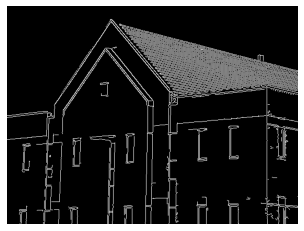

In [3]:
dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)
dst = cv2.Canny(dom, 100, 200, None, 3, 1)
plt.imshow(dst, 'gray')
plt.axis('off')
plt.show()